In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import warnings
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb

In [2]:
data = pd.read_csv(r'C:\Users\karen\OneDrive\Escritorio\Especializacion\ML1\data\fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Me fijo si hay observaciones duplicadas
duplic = data.duplicated()
num_duplicates = duplic.sum()
print("Cantidad de filas duplicadas:", num_duplicates)

Cantidad de filas duplicadas: 0


In [4]:
# Eliminar columnas irrelevantes 
data = data.drop(["nameOrig", "nameDest"], axis=1)

In [5]:
data.shape

(6362620, 9)

In [6]:
# Veo si hay missing values
data.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [9]:
# Separo tipos de variables para analizar

# Obtener los nombres de las columnas categóricas
cat_cols = data.select_dtypes(include='object').columns
print("Variables categóricas en el dataset:")
for col in cat_cols:
    print(col)

# Obtener los nombres de las columnas numéricas
num_cols = data.select_dtypes(include='number').columns
print("Variables numéricas en el dataset:")
for col in num_cols:
    print(col)

Variables categóricas en el dataset:
type
Variables numéricas en el dataset:
step
amount
oldbalanceOrg
newbalanceOrig
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud


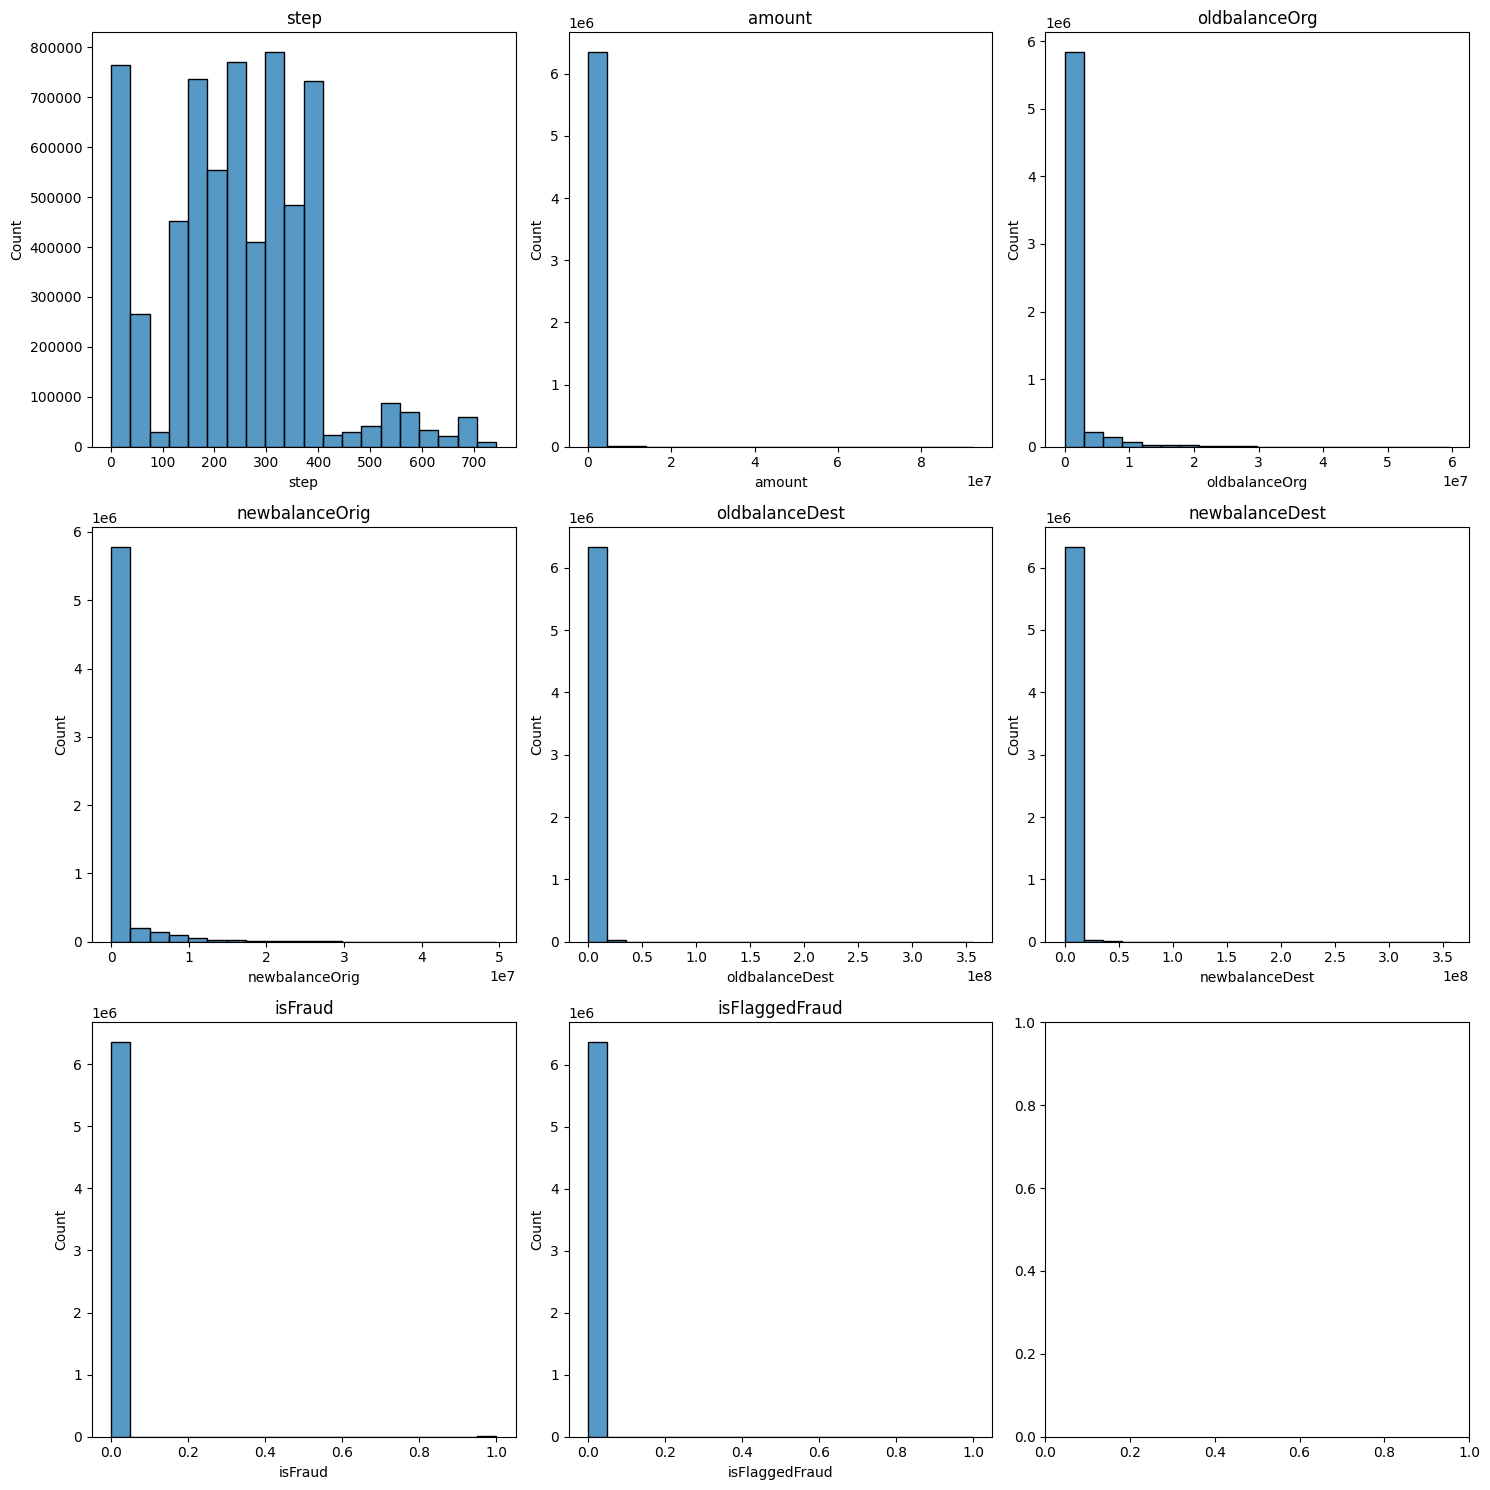

In [10]:
# Explorar las variables numéricas
if num_cols.any():
    num_col = 3
    num_row = -(-len(num_cols) // num_col)  # ceil division
    fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(15, 5*num_row))

    for i, col in enumerate(num_cols):
        row = i // num_col
        sns.histplot(data[col], ax=axs[row, i % num_col], bins=20)
        axs[row, i % num_col].set(title=col)

    plt.tight_layout()
    plt.savefig('histograms.png', dpi=300)
    plt.show()
else:
    print("No hay variables numéricas en los datos.")

In [11]:
# Verificar el balance de clases
fraud_count = data["isFraud"].sum()
non_fraud_count = len(data) - fraud_count
fraud_percentage = (fraud_count / len(data)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 8213 (0.13%)
Transacciones no fraudulentas: 6354407 (99.87%)


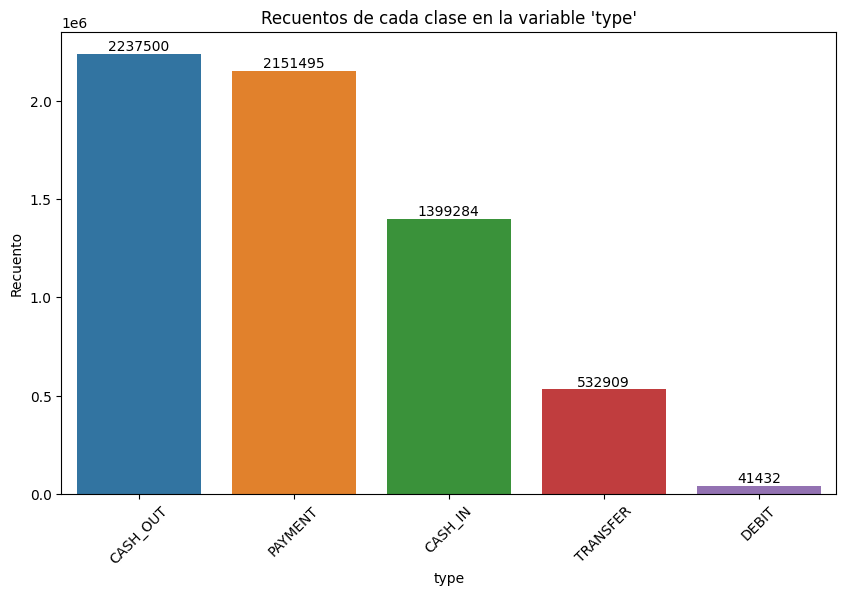

In [12]:
# Exploro los tipos de transacción

# Obtener los recuentos de cada clase
counts = data['type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title(f"Recuentos de cada clase en la variable '{'type'}'")
plt.xlabel('type')
plt.ylabel("Recuento")
plt.xticks(rotation=45)

# Agregar los valores en las barras
for i, count in enumerate(counts.values):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

In [13]:
# Calcular los recuentos de cada categoría y la cantidad de elementos fraudulentos y no fraudulentos
counts = data['type'].value_counts()
fraud_counts = data[data['isFraud'] == 1]['type'].value_counts()
non_fraud_counts = data[data['isFraud'] == 0]['type'].value_counts()

# Crear la tabla
tabla = pd.DataFrame({'Recuento total': counts, 'Recuento de fraudes': fraud_counts, 'Recuento de no fraudes': non_fraud_counts})
tabla.index.name = 'type'

print(tabla)

          Recuento total  Recuento de fraudes  Recuento de no fraudes
type                                                                 
CASH_IN          1399284                  NaN                 1399284
CASH_OUT         2237500               4116.0                 2233384
DEBIT              41432                  NaN                   41432
PAYMENT          2151495                  NaN                 2151495
TRANSFER          532909               4097.0                  528812


Sólo hay transacciones fraudulentas en CASH_OUT y TRANSFER

In [14]:
types = data['type'].unique()

for type_value in types:
    globals()[f"{type_value.lower()}_df"] = data[data['type'] == type_value].copy()
    globals()[f"{type_value.lower()}_df"].drop('type', axis=1, inplace=True)

In [15]:
transfer_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,181.00,181.00,0.0,0.00,0.00,1,0
19,1,215310.30,705.00,0.0,22425.00,0.00,0,0
24,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,0
58,1,62610.80,79114.00,16503.2,517.00,8383.29,0,0
78,1,42712.39,10363.39,0.0,57901.66,24044.18,0,0


In [16]:
cash_out_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,181.00,181.00,0.0,21182.0,0.00,1,0
15,1,229133.94,15325.00,0.0,5083.0,51513.44,0,0
42,1,110414.71,26845.41,0.0,288800.0,2415.16,0,0
47,1,56953.90,1942.02,0.0,70253.0,64106.18,0,0
48,1,5346.89,0.00,0.0,652637.0,6453430.91,0,0


Para incorporar la optimización de las ganancias en el entrenamiento del modelo de clasificación, se puede usar Cost-Sensitive Learning. Esta técnica asigna pesos diferentes a las clases en función de su costo asociado, de modo que el modelo se enfoque en minimizar los errores costosos. El objetivo es ajustar el equilibrio entre la clase positiva (fraude) y la clase negativa (no fraude) para mejorar el rendimiento del modelo en la detección de la clase minoritaria (fraude) teniendo en cuenta determinada función de coste.

En este caso, se busca maximizar la ganancia esperada teniendo en cuenta que por cada transacción aprobada el porcentaje de ganancia es de un 20% y por cada fraude aprobado se pierde el 100% del dinero de la transacción. Para lograr esto, voy a definir manualmente diferentes pesos de clase, calcular la ganancia esperada para cada configuración de pesos de clase y seleccionar el modelo que obtenga la ganancia más alta. Este enfoque considera tanto el desequilibrio de clases como la ganancia esperada, lo que te permite evaluar y seleccionar el modelo que ofrece el mejor equilibrio entre la precisión en la detección de casos de fraude y la ganancia asociada a esos casos.

Es importante tener en cuenta que el ajuste de los pesos de clase es una de las estrategias para manejar el desequilibrio de clases, pero hay otras técnicas disponibles, como el submuestreo, el sobremuestreo, la generación sintética de ejemplos y el uso de algoritmos específicos para desequilibrio de clases. La elección de la técnica adecuada depende del problema específico y de las características de los datos.

### Transfer

In [17]:
# Verificar el balance de clases
fraud_count = transfer_df["isFraud"].sum()
non_fraud_count = len(transfer_df) - fraud_count
fraud_percentage = (fraud_count / len(transfer_df)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 4097 (0.77%)
Transacciones no fraudulentas: 528812 (99.23%)


In [18]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = transfer_df.drop('isFraud', axis=1)
y = transfer_df['isFraud']

In [19]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
3243756,250,3315876.61,5412.0,0.0,94702.35,3410578.96,0
4938043,350,1196860.54,57074.0,0.0,69766.62,1266627.15,0
5083950,355,261328.52,40006.0,0.0,0.00,261328.52,0
336698,16,466989.62,137.0,0.0,0.00,787420.08,0
1317264,136,487035.87,159111.0,0.0,0.00,487035.87,0


In [21]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5,6
0,0.023845,1.286311,-0.112077,-0.040191,-0.411442,-0.018442,-0.00508
1,0.713620,0.153542,0.006025,-0.040191,-0.415603,-0.310889,-0.00508
2,0.748108,-0.346568,-0.032994,-0.040191,-0.427246,-0.448018,-0.00508
3,-1.590227,-0.236627,-0.124136,-0.040191,-0.427246,-0.376256,-0.00508
4,-0.762498,-0.225911,0.239285,-0.040191,-0.427246,-0.417230,-0.00508


#### Regresión logística

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.18
--------------------
Iteración: 3
Peso de clase: 1.37
--------------------
Iteración: 4
Peso de clase: 1.55
--------------------
Iteración: 5
Peso de clase: 1.73
--------------------
Iteración: 6
Peso de clase: 1.92
--------------------
Iteración: 7
Peso de clase: 2.1
--------------------
Iteración: 8
Peso de clase: 2.29
--------------------
Iteración: 9
Peso de clase: 2.47
--------------------
Iteración: 10
Peso de clase: 2.65
--------------------
Iteración: 11
Peso de clase: 2.84
--------------------
Iteración: 12
Peso de clase: 3.02
--------------------
Iteración: 13
Peso de clase: 3.2
--------------------
Iteración: 14
Peso de clase: 3.39
--------------------
Iteración: 15
Peso de clase: 3.57
--------------------
Iteración: 16
Peso de clase: 3.76
--------------------
Iteración: 17
Peso de clase: 3.94
--------------------
Iteración: 18
Peso de clase: 4.12
--------------------
Iteración: 19
Peso de 

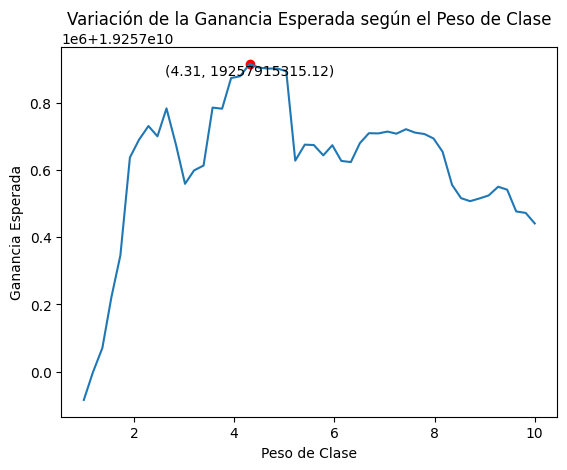

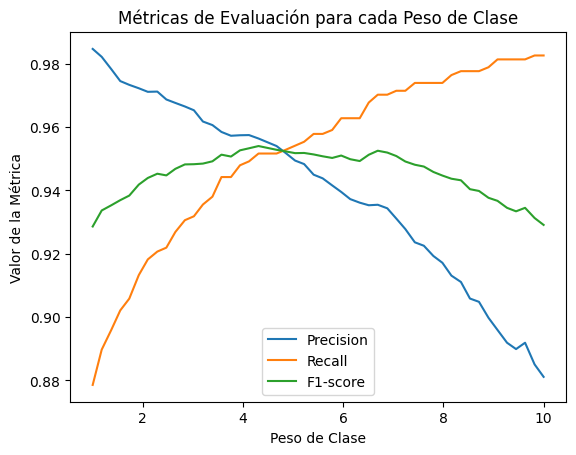

In [23]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0077
# weights = np.linspace(1, desbalance, 30) 
weights = np.linspace(1, 10, 50) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

Pruebo usando pesos menores para la clase mayoritaria

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.02
--------------------
Iteración: 3
Peso de clase: 1.04
--------------------
Iteración: 4
Peso de clase: 1.06
--------------------
Iteración: 5
Peso de clase: 1.08
--------------------
Iteración: 6
Peso de clase: 1.1
--------------------
Iteración: 7
Peso de clase: 1.12
--------------------
Iteración: 8
Peso de clase: 1.14
--------------------
Iteración: 9
Peso de clase: 1.16
--------------------
Iteración: 10
Peso de clase: 1.18
--------------------
Iteración: 11
Peso de clase: 1.2
--------------------
Iteración: 12
Peso de clase: 1.22
--------------------
Iteración: 13
Peso de clase: 1.24
--------------------
Iteración: 14
Peso de clase: 1.27
--------------------
Iteración: 15
Peso de clase: 1.29
--------------------
Iteración: 16
Peso de clase: 1.31
--------------------
Iteración: 17
Peso de clase: 1.33
--------------------
Iteración: 18
Peso de clase: 1.35
--------------------
Iteración: 19
Peso de 

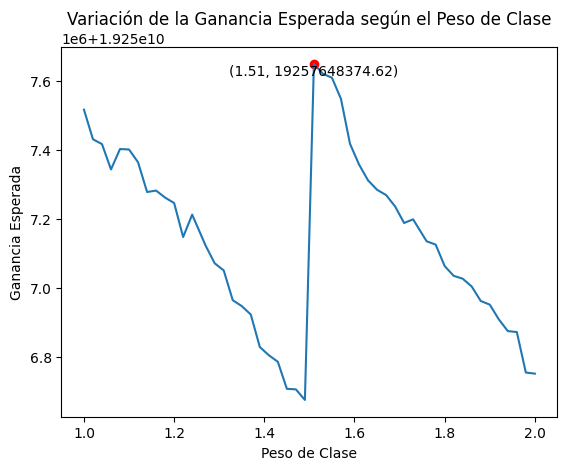

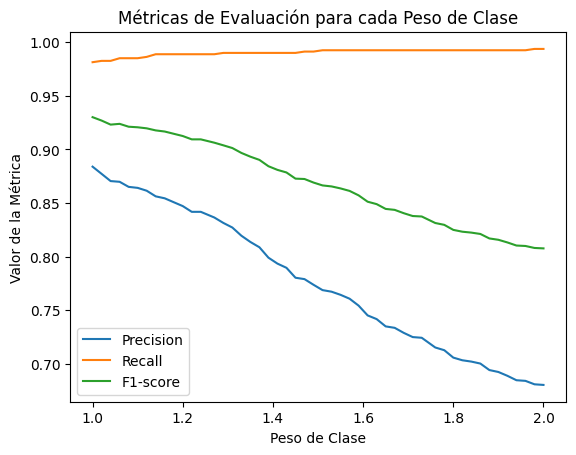

In [24]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
weights = np.linspace(1, 2, 50) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, se le asigna un peso de 0.1 a la clase no fraude
    class_weights = {0: 0.1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Random forest

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 3.63
--------------------
Iteración: 3
Peso de clase: 6.26
--------------------
Iteración: 4
Peso de clase: 8.89
--------------------
Iteración: 5
Peso de clase: 11.52
--------------------
Iteración: 6
Peso de clase: 14.15
--------------------
Iteración: 7
Peso de clase: 16.78
--------------------
Iteración: 8
Peso de clase: 19.41
--------------------
Iteración: 9
Peso de clase: 22.04
--------------------
Iteración: 10
Peso de clase: 24.67
--------------------
Iteración: 11
Peso de clase: 27.3
--------------------
Iteración: 12
Peso de clase: 29.93
--------------------
Iteración: 13
Peso de clase: 32.56
--------------------
Iteración: 14
Peso de clase: 35.19
--------------------
Iteración: 15
Peso de clase: 37.82
--------------------
Iteración: 16
Peso de clase: 40.45
--------------------
Iteración: 17
Peso de clase: 43.08
--------------------
Iteración: 18
Peso de clase: 45.71
--------------------
Iteraci

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteración: 50
Peso de clase: 129.87
--------------------


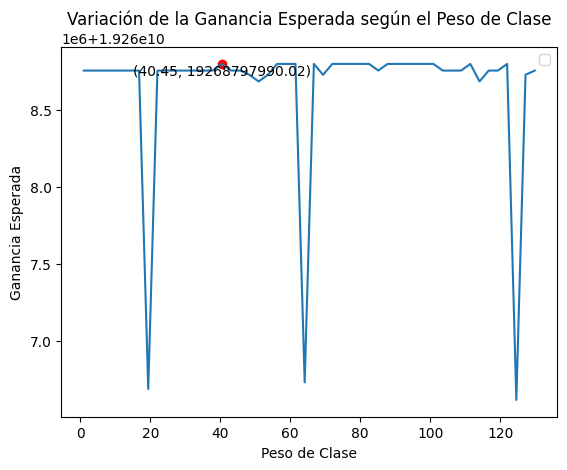

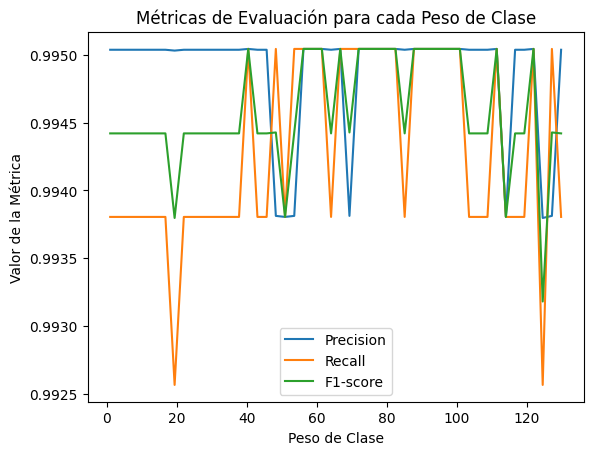

In [25]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
desbalance = 1/0.0077
weights = np.linspace(1, desbalance, 50) 
# weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### XGBoost

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 3.63
--------------------
Iteración: 3
Peso de clase: 6.26
--------------------
Iteración: 4
Peso de clase: 8.89
--------------------
Iteración: 5
Peso de clase: 11.52
--------------------
Iteración: 6
Peso de clase: 14.15
--------------------
Iteración: 7
Peso de clase: 16.78
--------------------
Iteración: 8
Peso de clase: 19.41
--------------------
Iteración: 9
Peso de clase: 22.04
--------------------
Iteración: 10
Peso de clase: 24.67
--------------------
Iteración: 11
Peso de clase: 27.3
--------------------
Iteración: 12
Peso de clase: 29.93
--------------------
Iteración: 13
Peso de clase: 32.56
--------------------
Iteración: 14
Peso de clase: 35.19
--------------------
Iteración: 15
Peso de clase: 37.82
--------------------
Iteración: 16
Peso de clase: 40.45
--------------------
Iteración: 17
Peso de clase: 43.08
--------------------
Iteración: 18
Peso de clase: 45.71
--------------------
Iteraci

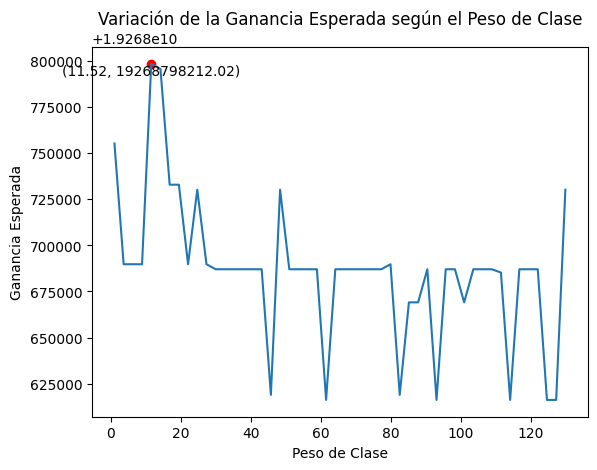

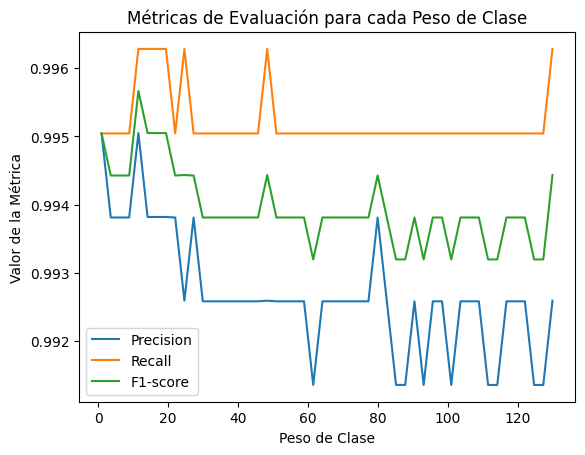

In [31]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
desbalance = 1/0.0077
weights = np.linspace(1, desbalance, 50) 
# weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### AutoML

##### Modelo final para TRANSFER

El modelo con mejor ganancia esperada fue un XGBoost con class_weights = {0: 1, 1: 11.52} 

In [36]:
def evaluar(y_test, y_train, y_pred, y_pred_is):

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('AUC-ROC:', roc_auc_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))

    cm = confusion_matrix(y_train, y_pred_is)
    sns.heatmap(cm, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de confusion - train data')
    plt.show()


    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de confusion - test data')
    plt.show()

Accuracy: 0.999934322868777
Precision: 0.995049504950495
Recall: 0.9962825278810409
F1: 0.9956656346749225
AUC-ROC: 0.9981223558809601
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105775
           1       1.00      1.00      1.00       807

    accuracy                           1.00    106582
   macro avg       1.00      1.00      1.00    106582
weighted avg       1.00      1.00      1.00    106582



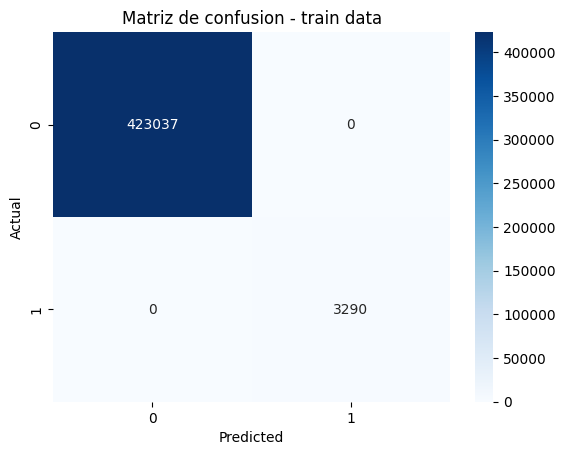

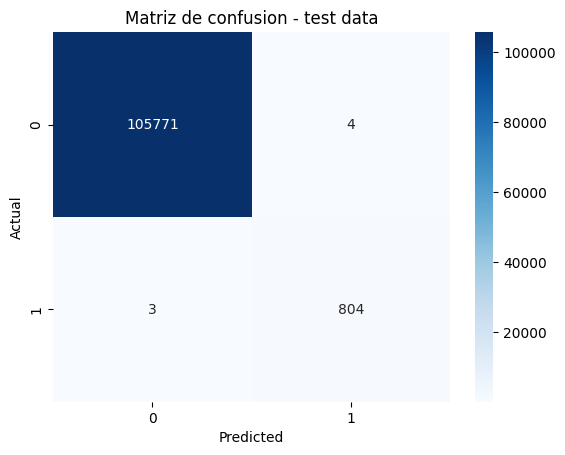

In [37]:
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=11.52)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
y_pred_is = model.predict(X_train_sc)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)

#### Cash_out

In [38]:
# Verificar el balance de clases
fraud_count = cash_out_df["isFraud"].sum()
non_fraud_count = len(cash_out_df) - fraud_count
fraud_percentage = (fraud_count / len(cash_out_df)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Transacciones fraudulentas: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Transacciones no fraudulentas: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Transacciones fraudulentas: 4116 (0.18%)
Transacciones no fraudulentas: 2233384 (99.82%)


In [39]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = cash_out_df.drop('isFraud', axis=1)
y = cash_out_df['isFraud']

In [40]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Verificar el balance de clases en train set
fraud_count = y_train.sum()
non_fraud_count = len(y_train) - fraud_count
fraud_percentage = (fraud_count / len(y_train)) * 100
non_fraud_percentage = 100 - fraud_percentage
print(f"Fraudulent transactions: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Non-fraudulent transactions: {non_fraud_count} ({non_fraud_percentage:.2f}%)")

Fraudulent transactions: 3279 (0.18%)
Non-fraudulent transactions: 1786721 (99.82%)


In [41]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
2886605,228,280552.81,204968.33,0.00,1432809.08,1713361.89,0
4856563,347,460820.30,54980.00,0.00,55726.68,516546.98,0
1776745,162,79118.36,70297.00,0.00,98344.79,177463.15,0
4608151,329,136339.64,0.00,0.00,6420331.26,6556670.90,0
1472786,141,53092.84,366067.00,312974.16,85463.30,138556.14,0


In [42]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)  # Estandarizamos los datos de entrenamiento
X_test_sc = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba
X_test_df = pd.DataFrame(X_test_sc)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5,6
0,-0.091756,0.593723,0.882097,-0.158226,-0.017550,0.006359,0.0
1,0.753389,1.619781,0.049769,-0.158226,-0.396758,-0.320487,0.0
2,-0.560492,-0.552813,0.134767,-0.158226,-0.385022,-0.413090,0.0
3,0.625552,-0.227118,-0.255331,-0.158226,1.355866,1.329053,0.0
4,-0.709636,-0.700947,1.776079,2.675079,-0.388569,-0.423715,0.0


#### Regresión logística

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.47
--------------------
Iteración: 3
Peso de clase: 1.95
--------------------
Iteración: 4
Peso de clase: 2.42
--------------------
Iteración: 5
Peso de clase: 2.89
--------------------
Iteración: 6
Peso de clase: 3.37
--------------------
Iteración: 7
Peso de clase: 3.84
--------------------
Iteración: 8
Peso de clase: 4.32
--------------------
Iteración: 9
Peso de clase: 4.79
--------------------
Iteración: 10
Peso de clase: 5.26
--------------------
Iteración: 11
Peso de clase: 5.74
--------------------
Iteración: 12
Peso de clase: 6.21
--------------------
Iteración: 13
Peso de clase: 6.68
--------------------
Iteración: 14
Peso de clase: 7.16
--------------------
Iteración: 15
Peso de clase: 7.63
--------------------
Iteración: 16
Peso de clase: 8.11
--------------------
Iteración: 17
Peso de clase: 8.58
--------------------
Iteración: 18
Peso de clase: 9.05
--------------------
Iteración: 19
Peso d

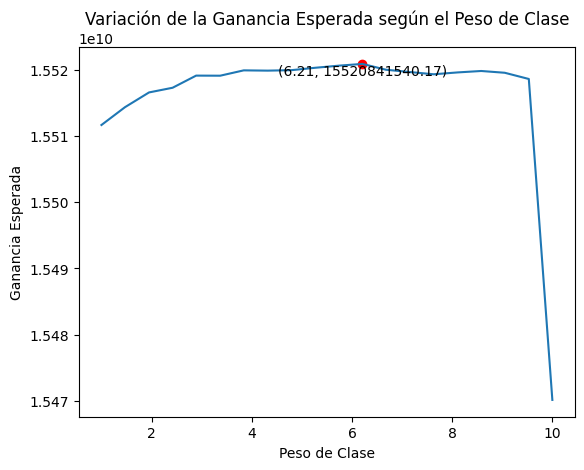

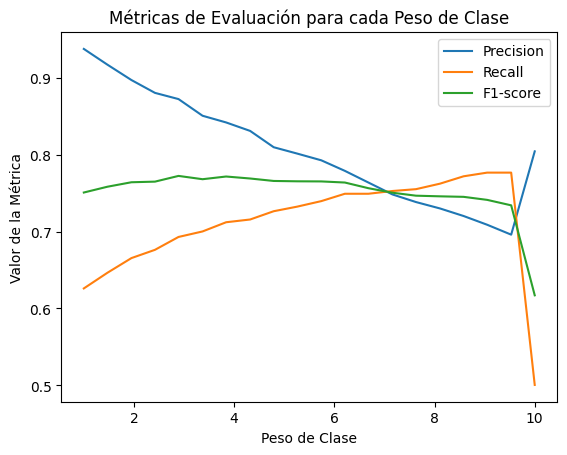

In [52]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
# desbalance = 1/0.0018
# weights = np.linspace(1, desbalance, 5) 
weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
#accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    #accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
# plt.plot(weights, accuracy_scores, label='Accuracy') # no tiene sentido ver accuracy con este nivel de desbalance
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

Pruebo usando pesos menores para la clase mayoritaria

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 1.05
--------------------
Iteración: 3
Peso de clase: 1.11
--------------------
Iteración: 4
Peso de clase: 1.16
--------------------
Iteración: 5
Peso de clase: 1.21
--------------------
Iteración: 6
Peso de clase: 1.26
--------------------
Iteración: 7
Peso de clase: 1.32
--------------------
Iteración: 8
Peso de clase: 1.37
--------------------
Iteración: 9
Peso de clase: 1.42
--------------------
Iteración: 10
Peso de clase: 1.47
--------------------
Iteración: 11
Peso de clase: 1.53
--------------------
Iteración: 12
Peso de clase: 1.58
--------------------
Iteración: 13
Peso de clase: 1.63
--------------------
Iteración: 14
Peso de clase: 1.68
--------------------
Iteración: 15
Peso de clase: 1.74
--------------------
Iteración: 16
Peso de clase: 1.79
--------------------
Iteración: 17
Peso de clase: 1.84
--------------------
Iteración: 18
Peso de clase: 1.89
--------------------
Iteración: 19
Peso d

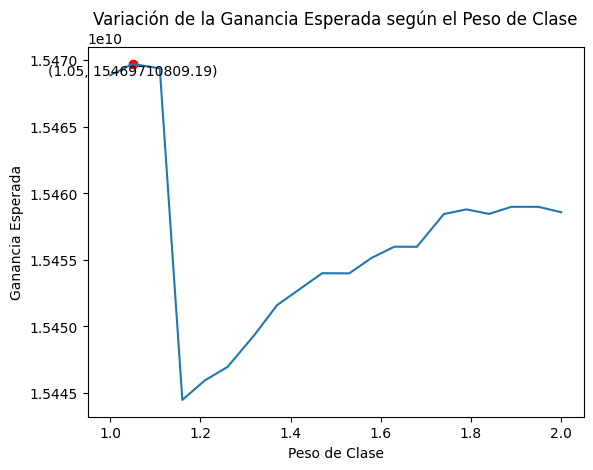

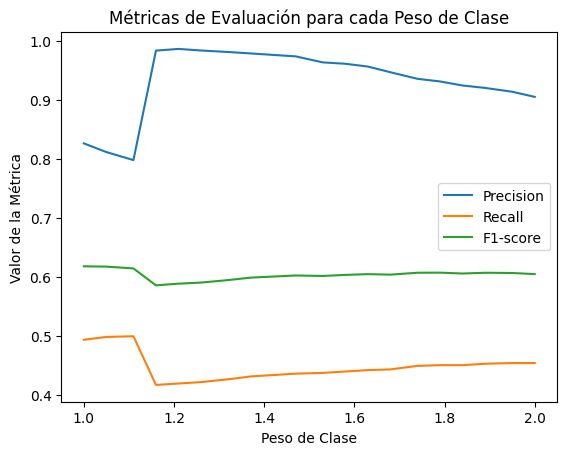

In [53]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
weights = np.linspace(1, 2, 20) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, se le asigna un peso de 0.1 a la clase no fraude
    class_weights = {0: 0.1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = LogisticRegressionCV(random_state=42, class_weight=class_weights, max_iter=100)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### Random Forest

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 30.19
--------------------
Iteración: 3
Peso de clase: 59.37
--------------------
Iteración: 4
Peso de clase: 88.56
--------------------
Iteración: 5
Peso de clase: 117.75
--------------------
Iteración: 6
Peso de clase: 146.94
--------------------
Iteración: 7
Peso de clase: 176.12
--------------------
Iteración: 8
Peso de clase: 205.31
--------------------
Iteración: 9
Peso de clase: 234.5
--------------------
Iteración: 10
Peso de clase: 263.68
--------------------
Iteración: 11
Peso de clase: 292.87
--------------------
Iteración: 12
Peso de clase: 322.06
--------------------
Iteración: 13
Peso de clase: 351.25
--------------------
Iteración: 14
Peso de clase: 380.43
--------------------
Iteración: 15
Peso de clase: 409.62
--------------------
Iteración: 16
Peso de clase: 438.81
--------------------
Iteración: 17
Peso de clase: 467.99
--------------------
Iteración: 18
Peso de clase: 497.18
-----------

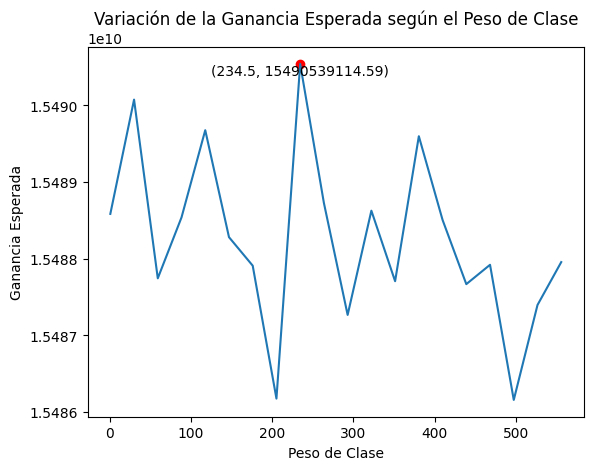

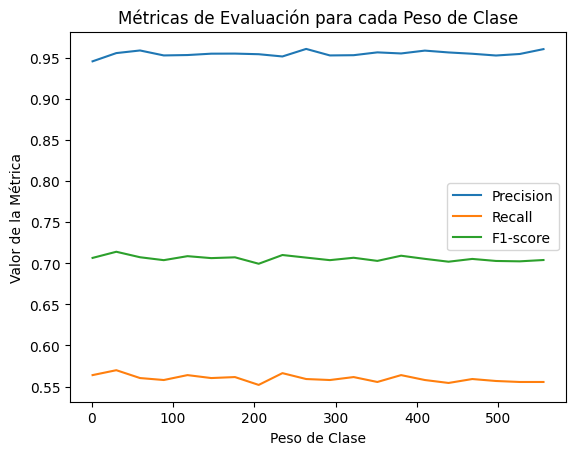

In [54]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
desbalance = 1/0.0018
weights = np.linspace(1, desbalance, 20) 
# weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

#### XGBoost

Iteración: 1
Peso de clase: 1.0
--------------------
Iteración: 2
Peso de clase: 20.12
--------------------
Iteración: 3
Peso de clase: 39.25
--------------------
Iteración: 4
Peso de clase: 58.37
--------------------
Iteración: 5
Peso de clase: 77.49
--------------------
Iteración: 6
Peso de clase: 96.61
--------------------
Iteración: 7
Peso de clase: 115.74
--------------------
Iteración: 8
Peso de clase: 134.86
--------------------
Iteración: 9
Peso de clase: 153.98
--------------------
Iteración: 10
Peso de clase: 173.1
--------------------
Iteración: 11
Peso de clase: 192.23
--------------------
Iteración: 12
Peso de clase: 211.35
--------------------
Iteración: 13
Peso de clase: 230.47
--------------------
Iteración: 14
Peso de clase: 249.59
--------------------
Iteración: 15
Peso de clase: 268.72
--------------------
Iteración: 16
Peso de clase: 287.84
--------------------
Iteración: 17
Peso de clase: 306.96
--------------------
Iteración: 18
Peso de clase: 326.08
-------------

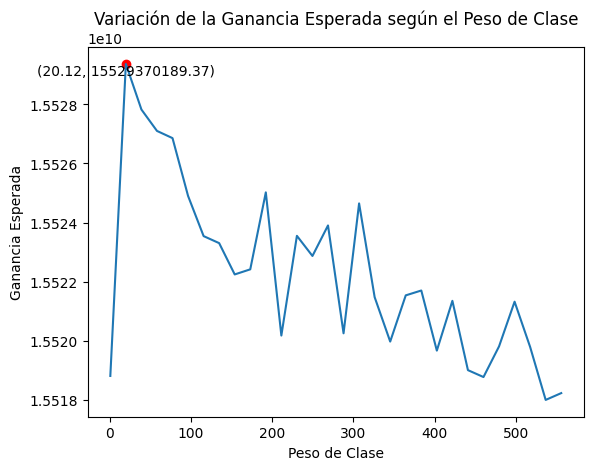

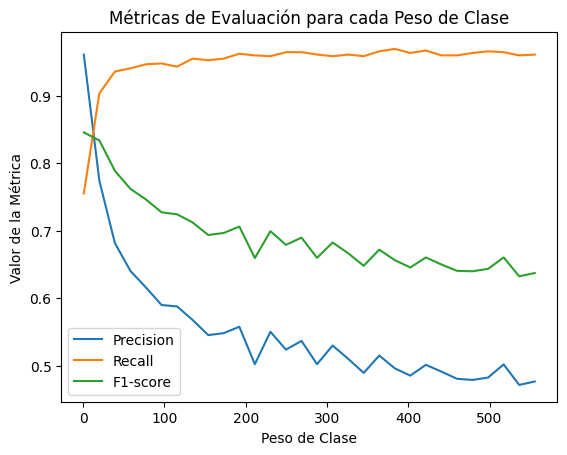

In [55]:
# Definir los diferentes pesos para ajustar el equilibrio de clases
# Probé primero con valores hasta el inverso del desequilibrio de clase, pero con pesos mayores a 10 la ganancia solo cae
desbalance = 1/0.0018
weights = np.linspace(1, desbalance, 30) 
# weights = np.linspace(1, 10, 20) 
weights = np.round(weights, decimals=2)
profits = []
precision_scores = []
recall_scores = []
f1_scores = []

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Iterar sobre los diferentes pesos de clase
for i, weight in enumerate(weights):
    # Itero los distintos pesos para la clase fraude, por default se le asigna un peso de 1 a la clase no fraude
    class_weights = {0: 1, 1: weight} 

    # Crear y entrenar el modelo con los pesos de clase modificados
    model = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight)
    model.fit(X_train_sc, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_sc)

    # Calcular las métricas de evaluación
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    #accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calcular las ganancias utilizando los porcentajes de ganancia y pérdida definidos
    results = X_test.copy()
    results['y_pred'] = y_pred
    results['y_test'] = y_test
    results['TP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 1), 1, 0)
    results['TN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 0), 1, 0)
    results['FP'] = np.where((results['y_pred'] == 1) & (results['y_test'] == 0), 1, 0)
    results['FN'] = np.where((results['y_pred'] == 0) & (results['y_test'] == 1), 1, 0)
    profit = (0.2 * results.loc[results['TN'] == 1, 'amount'].sum()) - results.loc[results['FN'] == 1, 'amount'].sum()
    profits.append(profit)

    # Imprimir los resultados
    print("Iteración:", i+1)
    print("Peso de clase:", weight)
    # print(classification_report(y_test,y_pred))
    print("--------------------")

# Gráfico de ganancias
max_index = profits.index(max(profits))
plt.plot(weights, profits)
plt.scatter(weights[max_index], profits[max_index], color='red', marker='o')
plt.xlabel('Peso de Clase')
plt.ylabel('Ganancia Esperada')
plt.title('Variación de la Ganancia Esperada según el Peso de Clase')
plt.annotate(f'({weights[max_index]}, {profits[max_index]:.2f})', xy=(weights[max_index], profits[max_index]),
             xytext=(weights[max_index], profits[max_index]-50),
             ha='center', va='top')
plt.show()

# Gráfico de métricas
plt.plot(weights, precision_scores, label='Precision')
plt.plot(weights, recall_scores, label='Recall')
plt.plot(weights, f1_scores, label='F1-score')
plt.xlabel('Peso de Clase')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Evaluación para cada Peso de Clase')
plt.legend()
plt.show()

##### Modelo final para CASH_OUT

El modelo con mejor ganancia esperada fue un XGBoost con class_weights = {0: 1, 1: 20.12} 

Accuracy: 0.9993251396648045
Precision: 0.7737973387922211
Recall: 0.9032258064516129
F1: 0.8335170893054025
AUC-ROC: 0.9513655131352908
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446663
           1       0.77      0.90      0.83       837

    accuracy                           1.00    447500
   macro avg       0.89      0.95      0.92    447500
weighted avg       1.00      1.00      1.00    447500



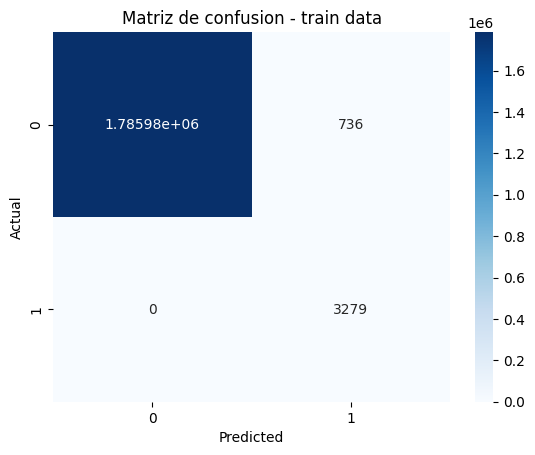

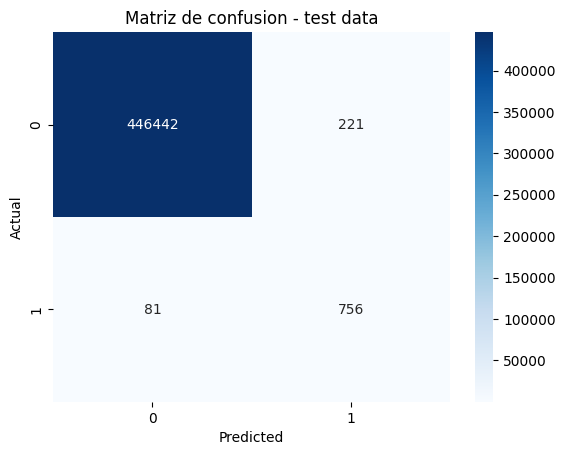

In [56]:
model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20.12)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
y_pred_is = model.predict(X_train_sc)

# Métricas de evaluación
evaluar(y_test, y_train, y_pred, y_pred_is)